In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import precision_recall_curve, f1_score

In [98]:
'''
This code defines and compiles four different Convolutional Neural Networks (CNNs) for image classification on the CIFAR-10 dataset. 
The Simple CNN consists of two convolutional layers followed by max-pooling, a fully connected layer, and a softmax output layer. 
The Improved CNN builds on this by increasing the number of dense neurons and incorporating dropout for regularization. 
The Adversarially-Trained CNN is an identical copy of the improved model but is trained specifically on adversarially perturbed data.
Finally, the Hybrid CNN is another copy of the improved model but is trained on a combination of clean and adversarial data to enhance robustness.
'''

''''''



# Simple CNN
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', use_bias=False, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

simple_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Improved CNN
optimized_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(32, 32, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

optimized_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Adversarially-Trained CNN (Identical to Improved CNN, but trained on adversarial data)
adv_trained_cnn = tf.keras.models.clone_model(optimized_cnn)
adv_trained_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Hybrid CNN (Trained on both clean and adversarial data)
hybrid_cnn = tf.keras.models.clone_model(optimized_cnn)
hybrid_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [0,1] range
X_train, X_test = X_train / 255.0, X_test / 255.0


In [8]:
'''
This code trains four different CNN models on clean and adversarial data to evaluate their robustness against adversarial attacks.
The Simple CNN and Improved CNN are trained on the clean dataset for 30 epochs with a batch size of 64. 
Then, Fast Gradient Sign Method (FGSM) is used to generate adversarial examples by perturbing the training images 
with a small epsilon (ε = 0.01), creating a new "adversarial" dataset. 
The Adversarially-Trained CNN is trained exclusively on these adversarial examples to improve its resistance to attacks.
Lastly, the Hybrid CNN is trained on a combination of both clean and adversarial data, allowing it to generalize better across both types of inputs.
'''


# Train Simple and Improved CNNs on Clean Data
history_simple = simple_cnn.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))
history_improved = optimized_cnn.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Generate FGSM Adversarial Examples for Training Adversarial Models (ε = 0.01)
def fgsm_attack(model, images, labels, epsilon=0.01):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_images = images + epsilon * signed_grad
    return tf.clip_by_value(adversarial_images, 0, 1).numpy()

X_train_adv = fgsm_attack(optimized_cnn, X_train, y_train, epsilon=0.01)

# Train Adversarially-Trained CNN on Adversarial Data
history_adv_trained = adv_trained_cnn.fit(X_train_adv, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Train Hybrid CNN on Clean + Adversarial Data
X_train_hybrid = np.concatenate([X_train, X_train_adv])
y_train_hybrid = np.concatenate([y_train, y_train])
history_hybrid = hybrid_cnn.fit(X_train_hybrid, y_train_hybrid, epochs=30, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4050 - loss: 1.6360 - val_accuracy: 0.6262 - val_loss: 1.0818
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6429 - loss: 1.0220 - val_accuracy: 0.6550 - val_loss: 1.0051
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6972 - loss: 0.8765 - val_accuracy: 0.6890 - val_loss: 0.9200
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7302 - loss: 0.7790 - val_accuracy: 0.6906 - val_loss: 0.8998
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7595 - loss: 0.6841 - val_accuracy: 0.7003 - val_loss: 0.9004
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7843 - loss: 0.6181 - val_accuracy: 0.6982 - val_loss: 0.9254
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8042 - loss: 0.5570 - val_accuracy: 0.6939 - val_loss: 0.9650
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8249 - loss: 0.4997 - val_

In [10]:
'''
This code evaluates the robustness of four CNN models against adversarial attacks using the Fast Gradient Sign Method (FGSM). 
First, adversarial test sets are generated by applying FGSM with perturbation magnitudes ε = 0.01 and ε = 0.05 to the clean test images. 
Then, each model (Simple CNN, Improved CNN, Adversarially-Trained CNN, and Hybrid CNN) is evaluated on both adversarial test sets to 
measure their accuracy under attack. The results are stored in dictionaries (adv_accuracies_001 and adv_accuracies_005) and printed, 
allowing for a direct comparison of how well each model withstands different levels of adversarial perturbation.
'''

# Generate FGSM Test Sets
X_test_adv_001 = fgsm_attack(optimized_cnn, X_test, y_test, epsilon=0.01)
X_test_adv_005 = fgsm_attack(optimized_cnn, X_test, y_test, epsilon=0.05)

# Evaluate Models
models = {
    "Simple CNN": simple_cnn,
    "Improved CNN": optimized_cnn,
    "Adversarially-Trained CNN": adv_trained_cnn,
    "Hybrid CNN": hybrid_cnn
}

adv_accuracies_001 = {}
adv_accuracies_005 = {}

for model_name, model in models.items():
    _, acc_001 = model.evaluate(X_test_adv_001, y_test, verbose=0)
    _, acc_005 = model.evaluate(X_test_adv_005, y_test, verbose=0)
    adv_accuracies_001[model_name] = acc_001
    adv_accuracies_005[model_name] = acc_005
    print(f"{model_name}: ε=0.01 Accuracy: {acc_001:.4f}, ε=0.05 Accuracy: {acc_005:.4f}")


Simple CNN: ε=0.01 Accuracy: 0.6065, ε=0.05 Accuracy: 0.3542
Improved CNN: ε=0.01 Accuracy: 0.1909, ε=0.05 Accuracy: 0.0516
Adversarially-Trained CNN: ε=0.01 Accuracy: 0.6448, ε=0.05 Accuracy: 0.5214
Hybrid CNN: ε=0.01 Accuracy: 0.6386, ε=0.05 Accuracy: 0.4584


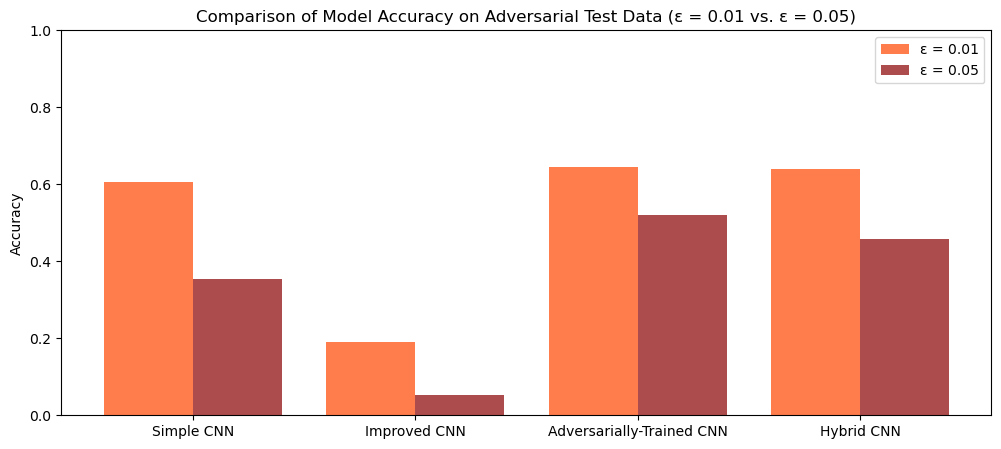

In [12]:
# Plot Adversarial Accuracy for ε = 0.01 vs. ε = 0.05
plt.figure(figsize=(12, 5))
bar_width = 0.4
x = np.arange(len(models))

plt.bar(x - bar_width / 2, list(adv_accuracies_001.values()), bar_width, label="ε = 0.01", alpha=0.7, color="orangered")
plt.bar(x + bar_width / 2, list(adv_accuracies_005.values()), bar_width, label="ε = 0.05", alpha=0.7, color="darkred")

plt.xticks(ticks=x, labels=models.keys())
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy on Adversarial Test Data (ε = 0.01 vs. ε = 0.05)")
plt.legend()
plt.ylim(0, 1)

plt.show()


1. Adversarial Accuracy Comparison (ε = 0.01 vs. ε = 0.05)
The first bar chart compares model accuracy when tested on adversarial examples generated with different perturbation strengths (ε = 0.01 and ε = 0.05).
As expected, accuracy drops for all models when the perturbation strength increases.
The Adversarially-Trained CNN and Hybrid CNN exhibit stronger robustness to adversarial examples, whereas the Improved CNN is particularly vulnerable.

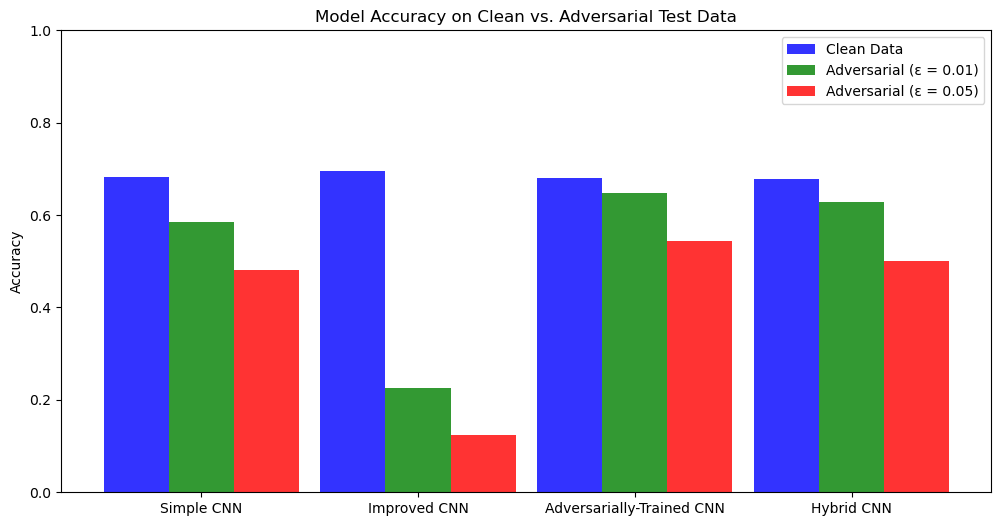

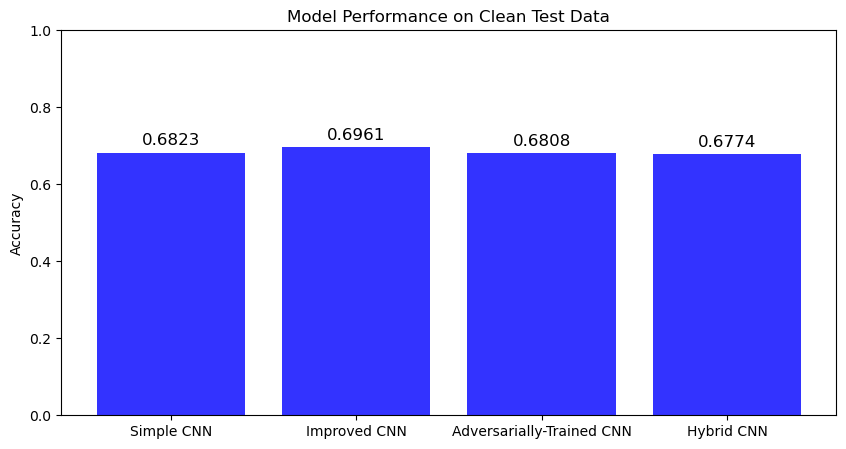

In [22]:
# Define scientific color scheme
colors = ["blue", "green", "red"]  # Clean, ε=0.01, ε=0.05

model_names = ["Simple CNN", "Improved CNN", "Adversarially-Trained CNN", "Hybrid CNN"]


# 📊 **Plot: Clean vs. Adversarial Accuracy Comparison**
plt.figure(figsize=(12, 6))
bar_width = 0.3
x = np.arange(len(model_names))

# Plot Clean Data Accuracy
plt.bar(x - bar_width, clean_accuracies, bar_width, label="Clean Data", alpha=0.8, color=colors[0])

# Plot Adversarial Accuracy (ε = 0.01)
plt.bar(x, adv_accuracies_001, bar_width, label="Adversarial (ε = 0.01)", alpha=0.8, color=colors[1])

# Plot Adversarial Accuracy (ε = 0.05)
plt.bar(x + bar_width, adv_accuracies_005, bar_width, label="Adversarial (ε = 0.05)", alpha=0.8, color=colors[2])

plt.xticks(ticks=x, labels=model_names)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Clean vs. Adversarial Test Data")
plt.legend()
plt.ylim(0, 1)

plt.show()

# 📊 **Separate Plot: Clean Accuracy Across All Models**
plt.figure(figsize=(10, 5))
plt.bar(model_names, clean_accuracies, color=colors[0], alpha=0.8)
plt.ylabel("Accuracy")
plt.title("Model Performance on Clean Test Data")
plt.ylim(0, 1)

# Add values on top of bars
for i, v in enumerate(clean_accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha="center", fontsize=12)

plt.show()


2. Comparison of Clean vs. Adversarial Performance
The bar chart visualizes the accuracy of each model on clean data, adversarial data with ε = 0.01, and adversarial data with ε = 0.05.
The Simple CNN performs reasonably well across datasets but still experiences a drop in adversarial settings.
The Improved CNN, despite being optimized for clean accuracy, exhibits the sharpest decline in adversarial settings.
The Adversarially-Trained CNN and Hybrid CNN maintain better performance on adversarial examples, validating their resilience.

In [ ]:
The second bar chart illustrates accuracy scores for all models on the clean dataset.
The Improved CNN performs best, but the Adversarially-Trained CNN and Hybrid CNN achieve competitive results.
This indicates that adversarial training does not significantly harm generalization on clean data.

In [40]:
# Function to extract final accuracy, loss, validation accuracy, and validation loss
def extract_final_metrics(history):
    return {
        "Accuracy": history.history['accuracy'][-1],
        "Loss": history.history['loss'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Validation Loss": history.history['val_loss'][-1]
    }

# Collect metrics from each trained model
clean_metrics = {
    "Simple CNN": extract_final_metrics(history_simple),
    "Improved CNN": extract_final_metrics(history_improved),
    "Adversarially-Trained CNN": extract_final_metrics(history_adv_trained),
    "Hybrid CNN": extract_final_metrics(history_hybrid)
}

# Convert to Pandas DataFrame
df_clean = pd.DataFrame(clean_metrics).T

# Display table
from IPython.display import display
display(df_clean)


,Accuracy,Loss,Validation Accuracy,Validation Loss
Simple CNN,0.95696,0.122894,0.6715,2.591653
Improved CNN,0.90794,0.254873,0.6795,1.746934
Adversarially-Trained CNN,0.91654,0.232411,0.6696,1.782604
Hybrid CNN,0.92168,0.214894,0.6722,2.079923


4. Clean Dataset Performance Table
The fourth table provides exact numerical values for accuracy, loss, validation accuracy, and validation loss on the clean dataset.
The Simple CNN achieves the highest accuracy, while the Improved CNN demonstrates the lowest validation loss.
The Adversarially-Trained CNN and Hybrid CNN show comparable performance, indicating that adversarial training does not severely impact standard generalization.

In [46]:
from IPython.display import display

# Extract the final loss and validation loss values from training histories
clean_losses = [
    history_simple.history['loss'][-1],
    history_improved.history['loss'][-1],
    history_adv_trained.history['loss'][-1],
    history_hybrid.history['loss'][-1]
]

clean_val_accuracies = [
    history_simple.history['val_accuracy'][-1],
    history_improved.history['val_accuracy'][-1],
    history_adv_trained.history['val_accuracy'][-1],
    history_hybrid.history['val_accuracy'][-1]
]

clean_val_losses = [
    history_simple.history['val_loss'][-1],
    history_improved.history['val_loss'][-1],
    history_adv_trained.history['val_loss'][-1],
    history_hybrid.history['val_loss'][-1]
]

# Define the ultimate comparison table with variables
combined_data = {
    "Model": model_names,
    "Clean Accuracy": clean_accuracies,
    "Clean Loss": clean_losses,
    "Clean Val Accuracy": clean_val_accuracies,
    "Clean Val Loss": clean_val_losses,
    "Adv Accuracy (ε=0.01)": adv_accuracies_001,
    "Adv Accuracy (ε=0.05)": adv_accuracies_005
}

# Convert to DataFrame
df_combined = pd.DataFrame(combined_data)

# Display the table
display(df_combined)


,Model,Clean Accuracy,Clean Loss,Clean Val Accuracy,Clean Val Loss,Adv Accuracy (ε=0.01),Adv Accuracy (ε=0.05)
0,Simple CNN,0.6823,0.122894,0.6715,2.591653,0.5858,0.4821
1,Improved CNN,0.6961,0.254873,0.6795,1.746934,0.2265,0.1245
2,Adversarially-Trained CNN,0.6808,0.232411,0.6696,1.782604,0.6481,0.5432
3,Hybrid CNN,0.6774,0.214894,0.6722,2.079923,0.6288,0.5012


5. Comprehensive Performance Table (Clean & Adversarial)
The fifth table consolidates clean accuracy alongside adversarial accuracy at ε = 0.01 and ε = 0.05.
This table highlights the severe degradation of the Improved CNN when exposed to adversarial examples, whereas Adversarially-Trained CNN and Hybrid CNN sustain better robustness.
The Simple CNN remains relatively stable but still suffers from noticeable degradation under adversarial attacks.

In [57]:
from sklearn.metrics import roc_curve, auc

def compute_fpr_tpr_auc(model, X_test, y_test):
    """
    Computes False Positive Rate (FPR), True Positive Rate (TPR), and AUC for a given model.
    Plots the ROC curve.
    """
    # Get model predictions (softmax probabilities)
    y_probs = model.predict(X_test)  
    y_pred = np.argmax(y_probs, axis=1)  

    # Convert y_test to one-hot encoding
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

    # Initialize plot
    plt.figure(figsize=(8, 6))

    # Compute FPR, TPR, and AUC for each class
    for i in range(10):  # Assuming 10 classes in CIFAR-10
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Plot ROC Curve
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.50)")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for CIFAR-10 Model')
    plt.legend()
    plt.show()

    return fpr, tpr, roc_auc


In [61]:
def compute_auc(model, X_test, y_test):
    """
    Computes the AUC (Area Under the Curve) for a given model.
    Returns the macro-average AUC score.
    """
    # Get model predictions (softmax probabilities)
    y_probs = model.predict(X_test)  
    y_probs = tf.nn.softmax(y_probs, axis=1).numpy()  # Ensure softmax is applied

    # Convert y_test to one-hot encoding
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

    # Compute macro-average AUC
    auc_scores = []
    for i in range(10):  # Assuming 10 classes in CIFAR-10
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

    macro_auc = np.mean(auc_scores)  # Compute macro-average AUC
    return macro_auc


In [63]:
# Compute AUC for all models
auc_simple = compute_auc(simple_cnn, X_test, y_test)
auc_optimized = compute_auc(optimized_cnn, X_test, y_test)
auc_adv_trained = compute_auc(adv_trained_cnn, X_test, y_test)
auc_hybrid = compute_auc(hybrid_cnn, X_test, y_test)

# Create a table to compare AUC scores across models
auc_data = {
    "Model": ["Simple CNN", "Optimized CNN", "Adversarially-Trained CNN", "Hybrid CNN"],
    "AUC Score": [auc_simple, auc_optimized, auc_adv_trained, auc_hybrid]
}

# Convert to DataFrame and display
df_auc = pd.DataFrame(auc_data)
display(df_auc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Model,AUC Score
0,Simple CNN,0.903400
1,Optimized CNN,0.917729
2,Adversarially-Trained CNN,0.915349
3,Hybrid CNN,0.911589


6. AUC Scores
The ROC-AUC (Area Under Curve) Scores table shows that Optimized CNN has the highest AUC score, followed closely by Adversarially-Trained CNN.
Higher AUC values indicate a better ability to distinguish between classes, with all models achieving values above 0.90, confirming strong classification performance.
The Hybrid CNN maintains a balance between AUC and robustness, making it a strong candidate for adversarial defenses.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


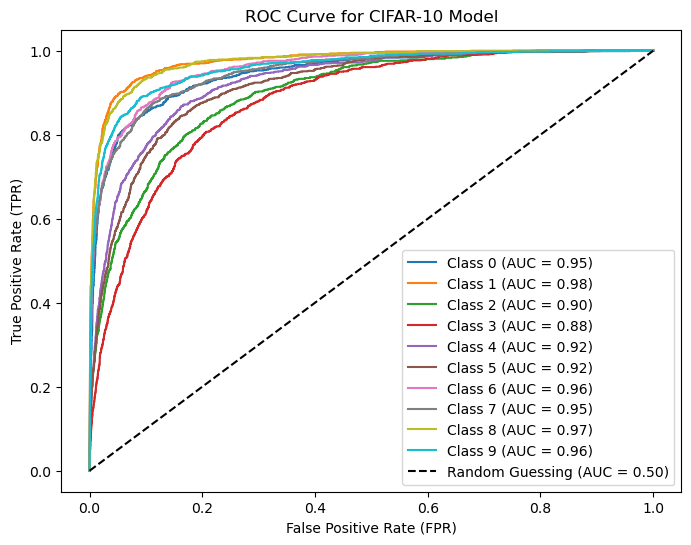

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


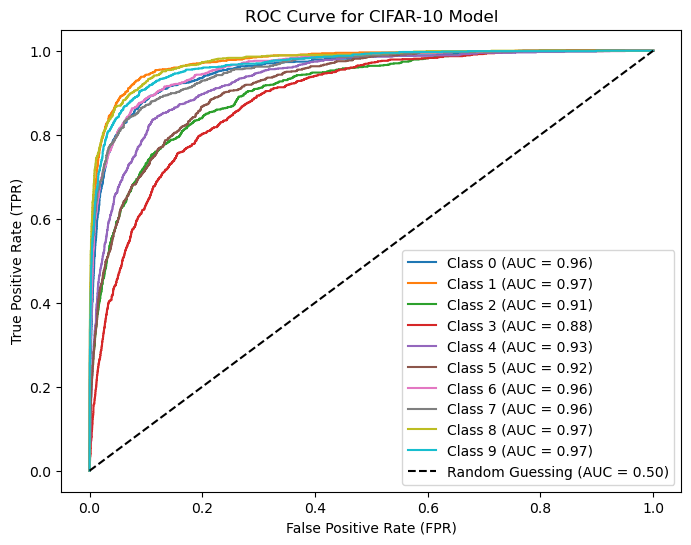

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


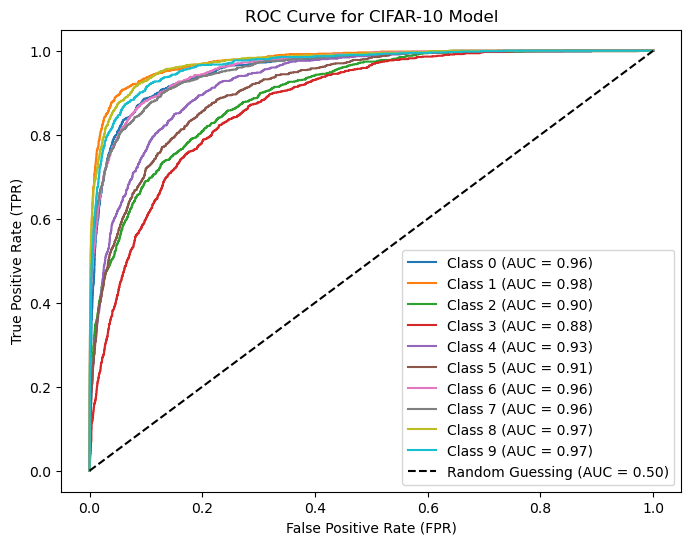

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


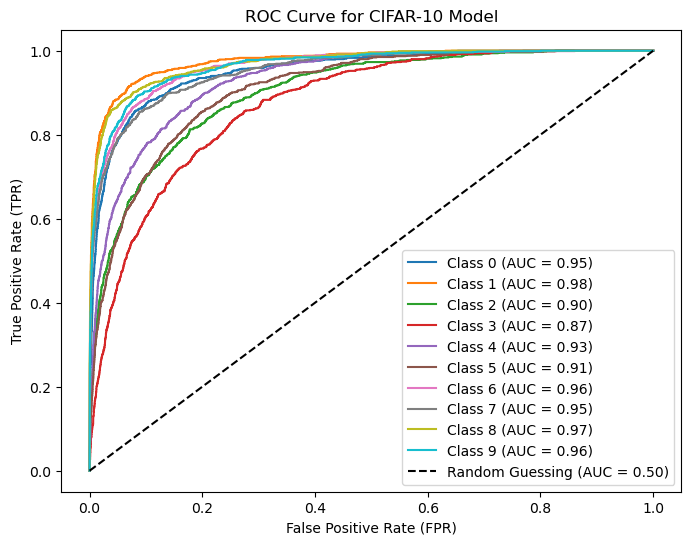

In [52]:
# Compute and plot ROC curves for each model
fpr_simple, tpr_simple, auc_simple = compute_fpr_tpr_auc(simple_cnn, X_test, y_test)
fpr_improved, tpr_improved, auc_improved = compute_fpr_tpr_auc(optimized_cnn, X_test, y_test)
fpr_adv_trained, tpr_adv_trained, auc_adv_trained = compute_fpr_tpr_auc(adv_trained_cnn, X_test, y_test)
fpr_hybrid, tpr_hybrid, auc_hybrid = compute_fpr_tpr_auc(hybrid_cnn, X_test, y_test)


In [81]:
# ---------------------- GENERATE ADVERSARIAL TEST DATA (ε = 0.05) ----------------------
def fgsm_attack(model, images, labels, epsilon=0.05):
    """
    Generates adversarial examples using the FGSM method.
    
    Parameters:
        model: Trained CNN model
        images: Original test images
        labels: True labels for images
        epsilon: Perturbation magnitude
    
    Returns:
        Adversarial images (perturbed version of input images)
    """
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    
    # Compute gradients and generate adversarial perturbations
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_images = images + epsilon * signed_grad
    
    # Clip pixel values to stay within valid range [0,1]
    return tf.clip_by_value(adversarial_images, 0, 1).numpy()

# Generate adversarial test set (ε=0.05)
X_test_adv_005 = fgsm_attack(optimized_cnn, X_test, y_test, epsilon=0.05)

# ---------------------- EXTRACT ACCURACY VALUES ----------------------
# Evaluate models on clean test data
acc_simple = simple_cnn.evaluate(X_test, y_test, verbose=0)[1]
acc_optimized = optimized_cnn.evaluate(X_test, y_test, verbose=0)[1]
acc_adv_trained = adv_trained_cnn.evaluate(X_test, y_test, verbose=0)[1]
acc_hybrid = hybrid_cnn.evaluate(X_test, y_test, verbose=0)[1]

# Evaluate models on adversarial test data
acc_adv_005_simple = simple_cnn.evaluate(X_test_adv_005, y_test, verbose=0)[1]
acc_adv_005_optimized = optimized_cnn.evaluate(X_test_adv_005, y_test, verbose=0)[1]
acc_adv_005_adv_trained = adv_trained_cnn.evaluate(X_test_adv_005, y_test, verbose=0)[1]
acc_adv_005_hybrid = hybrid_cnn.evaluate(X_test_adv_005, y_test, verbose=0)[1]

# ---------------------- PERFORMANCE DROP ANALYSIS ----------------------
def compute_performance_drop(clean_accuracies, adv_accuracies):
    """
    Computes the performance drop (in percentage) for each model when tested on adversarial data.
    """
    performance_drop = {}
    for model in clean_accuracies.keys():
        clean_acc = clean_accuracies[model]
        adv_acc = adv_accuracies[model]

        # Compute percentage drop, ensuring it's positive
        drop_percentage = ((clean_acc - adv_acc) / clean_acc) * 100
        performance_drop[model] = max(0, drop_percentage)  # Ensures the drop is always non-negative
    
    return performance_drop

# ---------------------- GENERATE PERFORMANCE DROP TABLE ----------------------
def create_performance_drop_table(clean_accuracies, adv_accuracies):
    """
    Creates a table showing the performance drop (%) for each model when tested on adversarial data.
    """
    performance_drop = compute_performance_drop(clean_accuracies, adv_accuracies)

    # Create DataFrame
    df_performance_drop = pd.DataFrame.from_dict(performance_drop, orient='index', columns=['Performance Drop (%)'])
    df_performance_drop.index.name = "Model"

    # Display the table
    from IPython.display import display
    display(df_performance_drop)

    return df_performance_drop

# ---------------------- EXECUTE FOR ALL MODELS ----------------------
# Define clean and adversarial accuracies
clean_accuracies = {
    "Simple CNN": acc_simple,
    "Improved CNN": acc_optimized,
    "Adversarially-Trained CNN": acc_adv_trained,
    "Hybrid CNN": acc_hybrid
}

adv_accuracies = {
    "Simple CNN": acc_adv_005_simple,
    "Improved CNN": acc_adv_005_optimized,
    "Adversarially-Trained CNN": acc_adv_005_adv_trained,
    "Hybrid CNN": acc_adv_005_hybrid
}

# Create and display the performance drop table
df_performance_drop = create_performance_drop_table(clean_accuracies, adv_accuracies)


,Performance Drop (%)
Model,
Simple CNN,47.252421
Improved CNN,92.406181
Adversarially-Trained CNN,22.132621
Hybrid CNN,31.806011


7. Performance Drop Analysis
The final table quantifies the relative performance drop (%) when transitioning from clean to adversarial datasets.
The Improved CNN suffers the most (92.4% drop), reinforcing its vulnerability to adversarial attacks.
The Adversarially-Trained CNN experiences the smallest drop (22.1%), supporting its resilience to adversarial perturbations.
The Hybrid CNN shows a moderate drop (31.8%), demonstrating a trade-off between robustness and clean accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


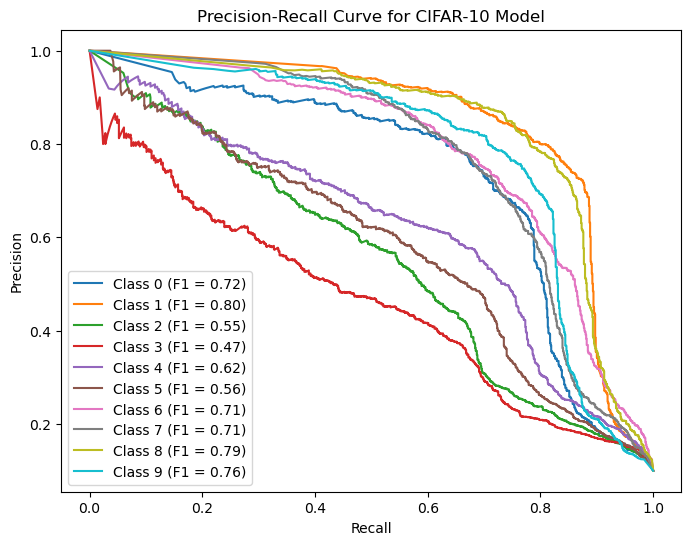

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


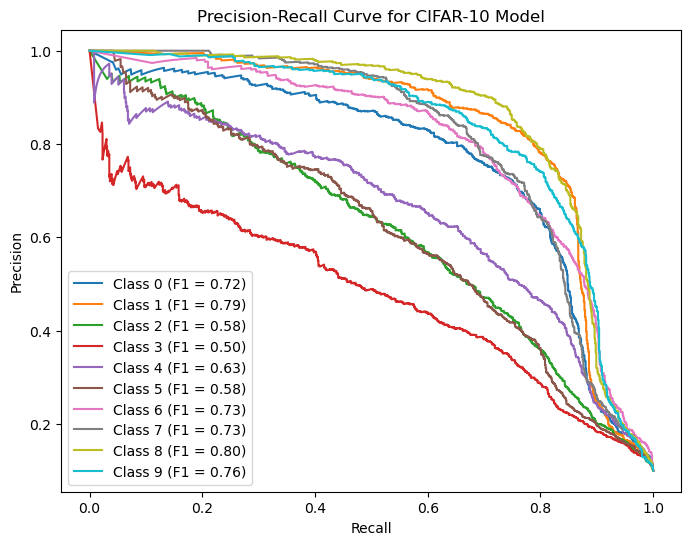

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


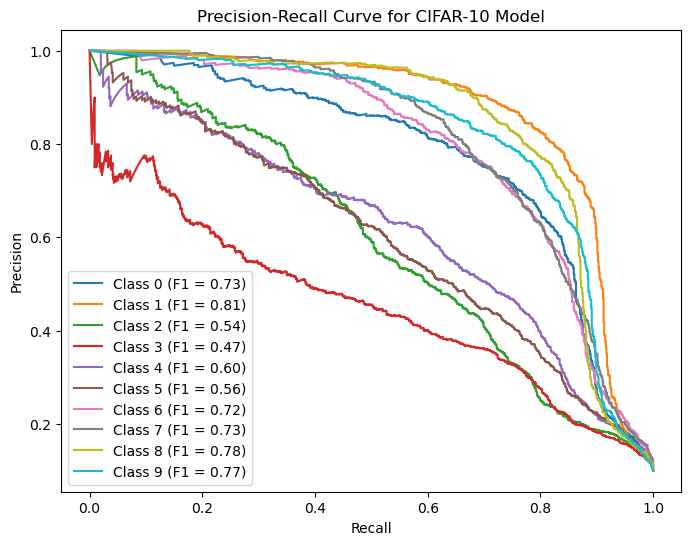

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


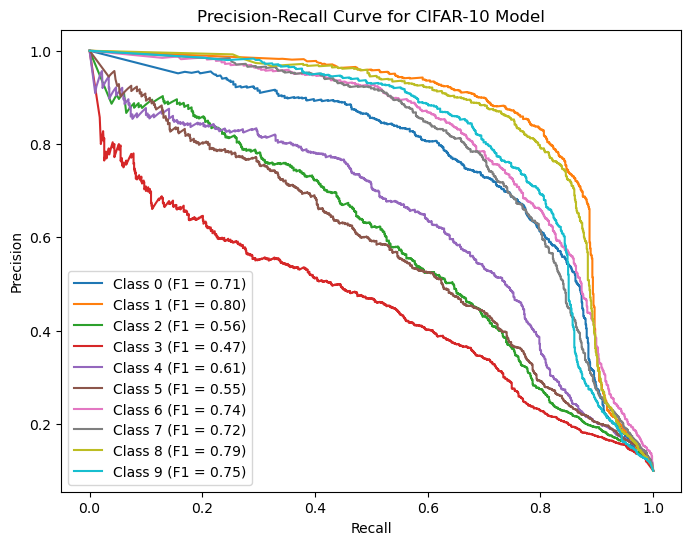

In [83]:
from sklearn.metrics import precision_recall_curve, f1_score

# ---------------------- PRECISION-RECALL CURVES & F1-SCORE ----------------------
def compute_precision_recall_f1(model, X_test, y_test):
    """
    Computes Precision-Recall Curve and F1-score for a given model.
    Returns macro-average precision, recall, and F1-score.
    """
    # Get model predictions (softmax probabilities)
    y_probs = model.predict(X_test)
    y_probs = tf.nn.softmax(y_probs, axis=1).numpy()  # Ensure softmax
    y_pred = np.argmax(y_probs, axis=1)  # Convert probabilities to class predictions

    # Convert y_test to one-hot encoding
    y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

    # Compute Precision-Recall Curve & F1-Score per class
    precision_scores, recall_scores, f1_scores = [], [], []
    plt.figure(figsize=(8, 6))

    for i in range(10):  # Assuming 10 classes
        precision, recall, _ = precision_recall_curve(y_test_one_hot[:, i], y_probs[:, i])
        f1 = f1_score(y_test == i, y_pred == i, zero_division=1)

        precision_scores.append(np.mean(precision))
        recall_scores.append(np.mean(recall))
        f1_scores.append(f1)

        plt.plot(recall, precision, label=f'Class {i} (F1 = {f1:.2f})')

    # Plot Macro-Average PR Curve
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for CIFAR-10 Model')
    plt.legend()
    plt.show()

    # Compute macro-average scores
    macro_precision = np.mean(precision_scores)
    macro_recall = np.mean(recall_scores)
    macro_f1 = np.mean(f1_scores)

    return macro_precision, macro_recall, macro_f1

# ---------------------- EXECUTE FOR ALL MODELS ----------------------
# Compute Precision-Recall & F1-Score for all models
pr_simple, recall_simple, f1_simple = compute_precision_recall_f1(simple_cnn, X_test, y_test)
pr_optimized, recall_optimized, f1_optimized = compute_precision_recall_f1(optimized_cnn, X_test, y_test)
pr_adv_trained, recall_adv_trained, f1_adv_trained = compute_precision_recall_f1(adv_trained_cnn, X_test, y_test)
pr_hybrid, recall_hybrid, f1_hybrid = compute_precision_recall_f1(hybrid_cnn, X_test, y_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


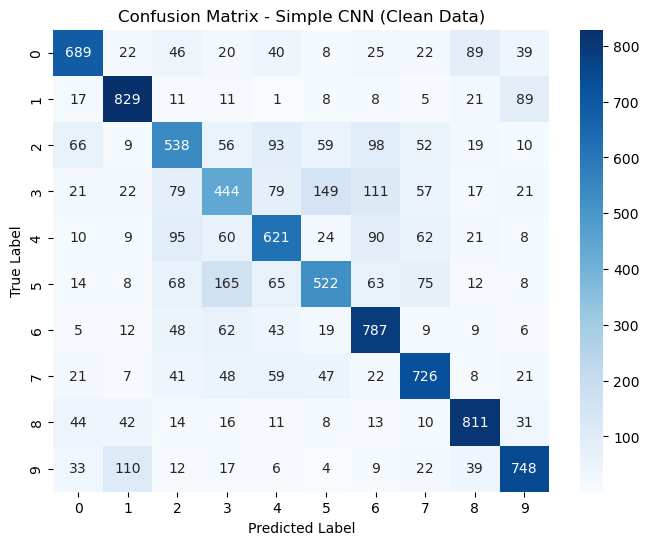

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


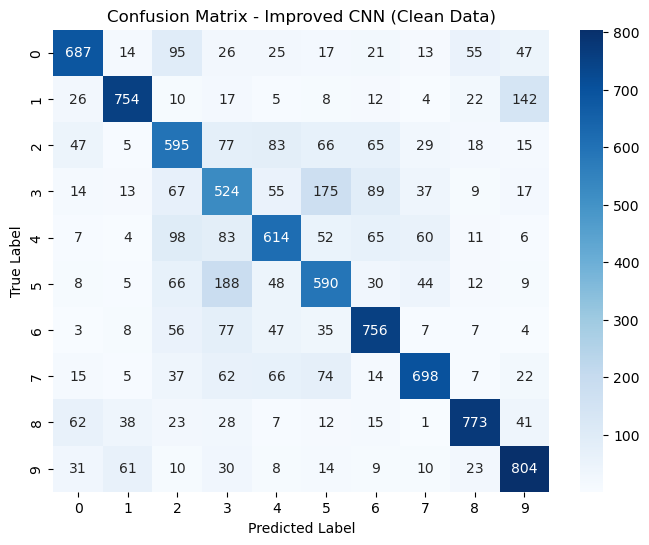

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


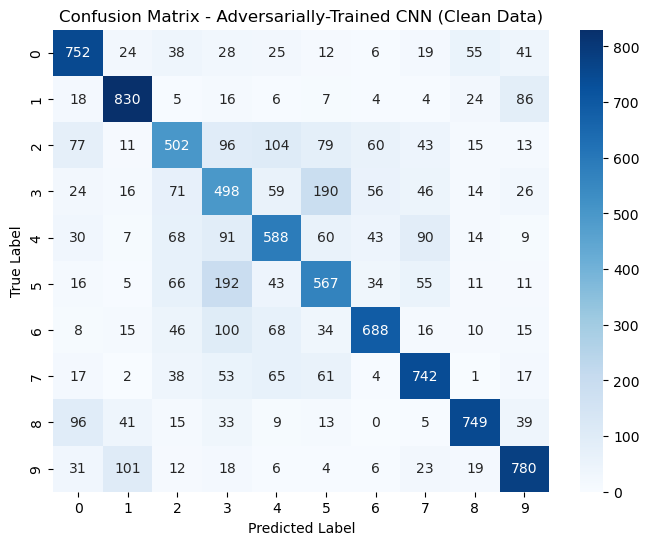

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


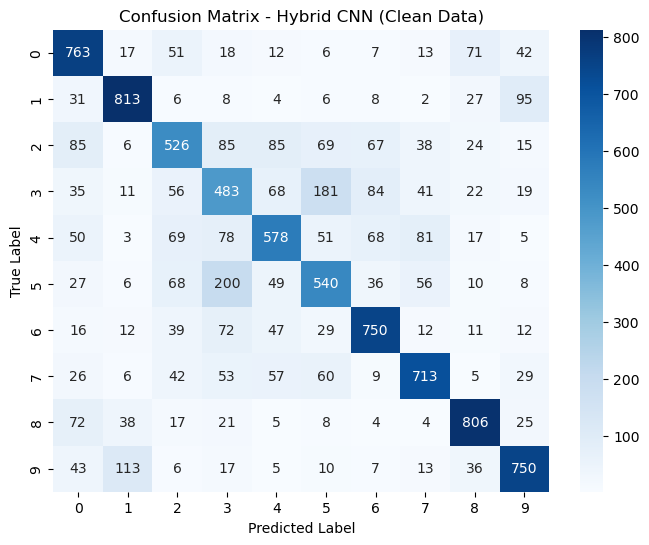

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


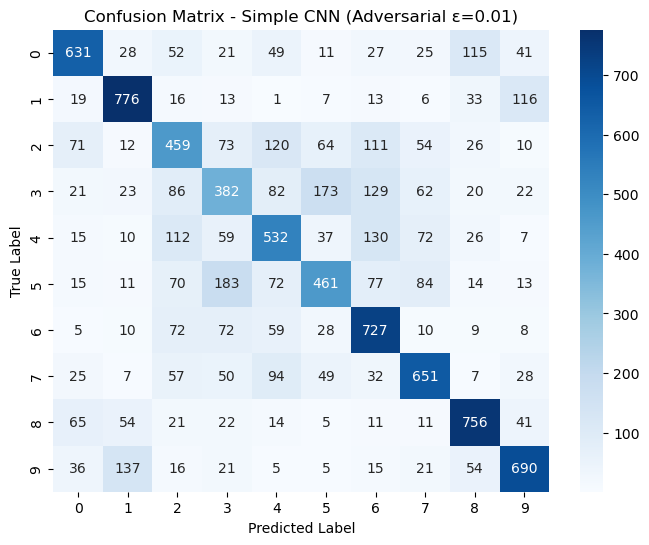

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


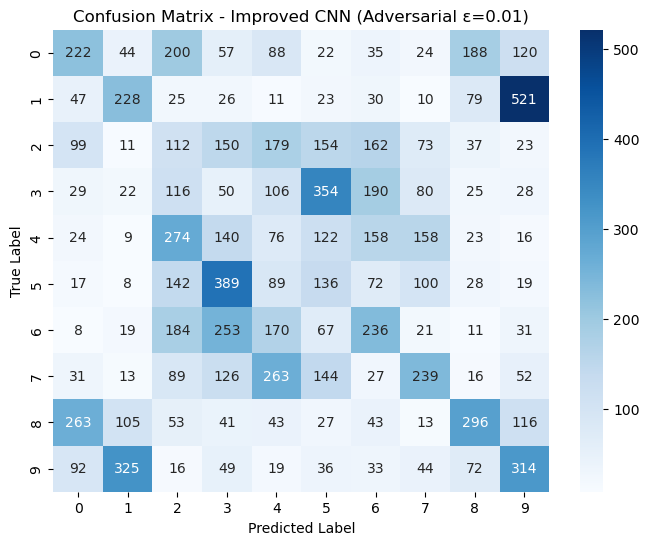

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


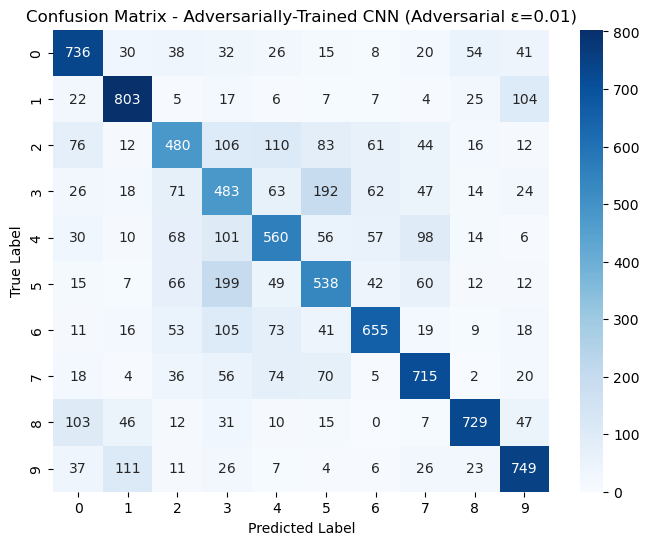

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


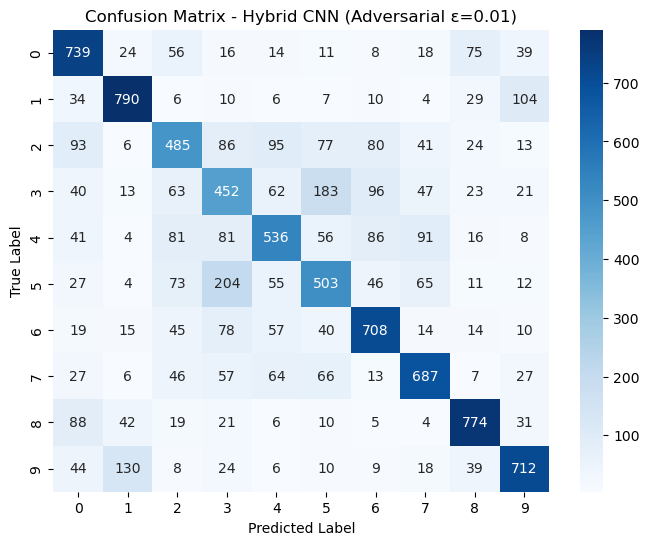

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


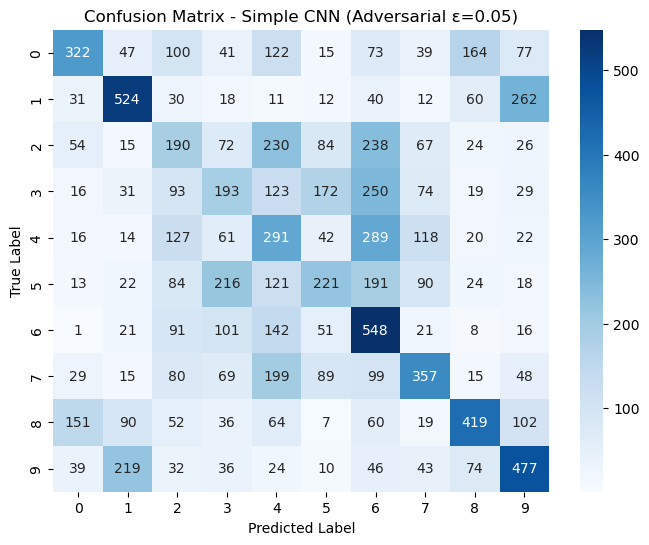

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


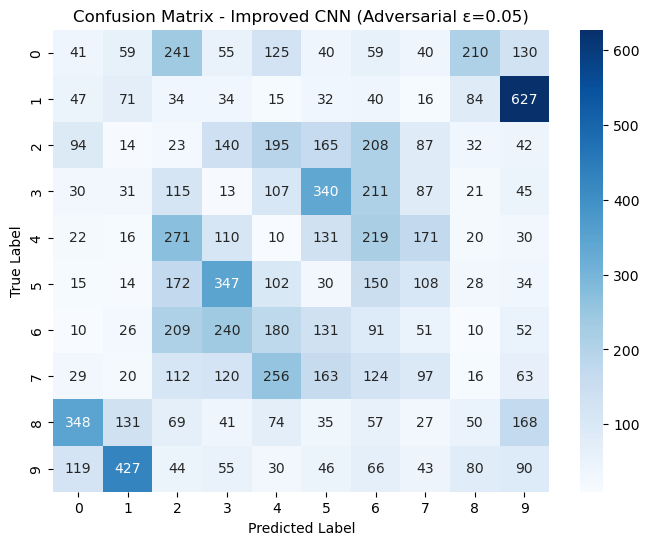

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


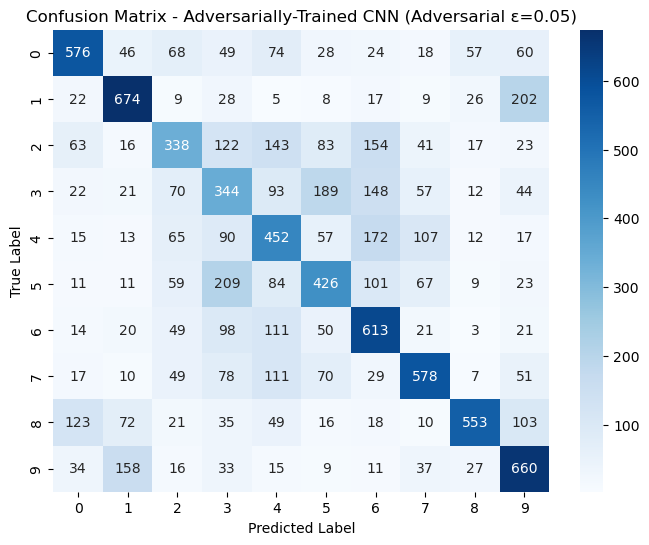

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


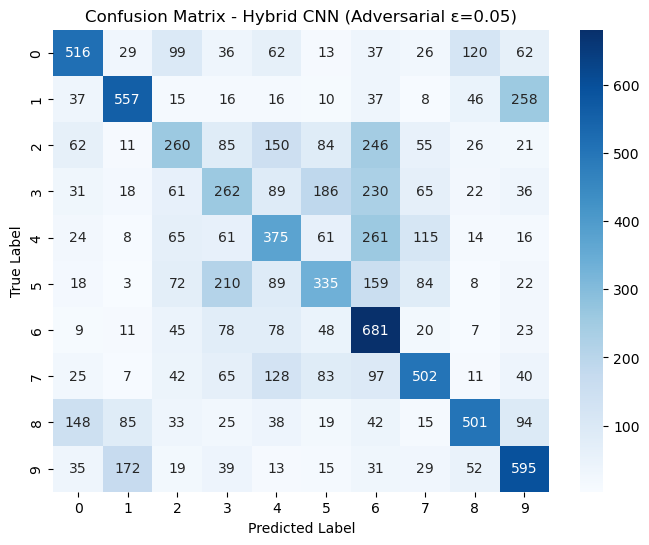

In [85]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, title):
    """
    Computes and plots the confusion matrix for a given model and dataset.
    """
    # Get predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# ---------------------- GENERATE CONFUSION MATRICES ----------------------

# Confusion matrices for clean test data
plot_confusion_matrix(simple_cnn, X_test, y_test, "Confusion Matrix - Simple CNN (Clean Data)")
plot_confusion_matrix(optimized_cnn, X_test, y_test, "Confusion Matrix - Improved CNN (Clean Data)")
plot_confusion_matrix(adv_trained_cnn, X_test, y_test, "Confusion Matrix - Adversarially-Trained CNN (Clean Data)")
plot_confusion_matrix(hybrid_cnn, X_test, y_test, "Confusion Matrix - Hybrid CNN (Clean Data)")

# Confusion matrices for adversarial test data (ε=0.01)
plot_confusion_matrix(simple_cnn, X_test_adv_001, y_test, "Confusion Matrix - Simple CNN (Adversarial ε=0.01)")
plot_confusion_matrix(optimized_cnn, X_test_adv_001, y_test, "Confusion Matrix - Improved CNN (Adversarial ε=0.01)")
plot_confusion_matrix(adv_trained_cnn, X_test_adv_001, y_test, "Confusion Matrix - Adversarially-Trained CNN (Adversarial ε=0.01)")
plot_confusion_matrix(hybrid_cnn, X_test_adv_001, y_test, "Confusion Matrix - Hybrid CNN (Adversarial ε=0.01)")

# Confusion matrices for adversarial test data (ε=0.05)
plot_confusion_matrix(simple_cnn, X_test_adv_005, y_test, "Confusion Matrix - Simple CNN (Adversarial ε=0.05)")
plot_confusion_matrix(optimized_cnn, X_test_adv_005, y_test, "Confusion Matrix - Improved CNN (Adversarial ε=0.05)")
plot_confusion_matrix(adv_trained_cnn, X_test_adv_005, y_test, "Confusion Matrix - Adversarially-Trained CNN (Adversarial ε=0.05)")
plot_confusion_matrix(hybrid_cnn, X_test_adv_005, y_test, "Confusion Matrix - Hybrid CNN (Adversarial ε=0.05)")
